# Import Packages


In [18]:
import uuid
import re
import pandas as pd
import random
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import evaluate

from transformers import pipeline, AutoTokenizer, DefaultDataCollator, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from datasets import Dataset
from tqdm.notebook import tqdm
from tqdm.auto import tqdm

# 1. Latar Belakang
Diberikan teks yang mengandung informasi pengiriman beberapa barang, kita ingin mengambil informasi meliputi:
* Barang-barang yang dipesan/dikirim
* Jumlah masing-masing barang yang dipesan/dikirim (jika ada)
* Motif dari barang tersebut (jika ada)
* Lokasi pengiriman (jika ada)

Untuk mendapatkan informasi dari teks tersebut kita dapat menggunakan model  *Natural Language Processing* (NLP) yaitu model pembelajaran mesin (*machine learning*) yang dapat mengolah data teks. Lebih lanjut lagi, kita akan menggunakan pendekatan *Question Answering* (QA) dengan cara menanyakan 3 pertanyaan berdasarkan konteks kalimat yang diberikan.

* Apa saja barang yang dipesan? 
* Apa motif dari barang tersebut?
* Ke mana barang tersebut dikirim?

Pada kasus ini, akan digunakan model Bidirectional Encoder Representations from Transformers (BERT) yang didesain khusus untuk mengatasi permasalahan tanya jawab atau *Question Answering*. Model ini memiliki kapabilitas yang lebih baik daripada model RNN terutama dalam menangkap konteks dari kalimat tersebut.

Adapun proses *training* dan evaluasi model akan menggunakan package *Huggingface*.

# 2. Pemrosesan Data
Untuk melatih model BERT dalam mengatasi permasalahan tersebut. Kita perlu membuat suatu data yang mengandung teks-teks serupa. Kita dapat menggunakan ChatGPT untuk membantu dalam pembuatan data, namun karena API dari ChatGPT ini berbayar kita dapat memilih alternatif lain yaitu membuat data dengan metode manual.


Ide dari pembuatan data ini adalah dengan menyediakan format kalimat perintah sebagai berikut:
1. "Saya mau memesan `num_1` `item_1` dan `num_2` `item_2` dengan motif `motif_1`"
2. "Tolong kirimkan `num_1` `item_1` dengan motif `motif_1` ke `lokasi_pengiriman_1`"
3. "Saya membutuhkan `item_1` dan `item_2` dengan motif `motif_1`"

Kata-kata yang ditandai di atas merupakan parameter dari kalimat tersebut, sebagai contoh apabila diberikan parameter sebagai berikut,

```
{"item": ["piring", "gelas"],
"num_item": [5, 4],
"lokasi":["Jakarta Selatan"],
"motif":["Floral"]}
```

Maka, kita bisa membuat beberapa teks sebagai berikut,
1. "Saya mau memesan 5 piring dan 4 gelas dengan motif Floral"
2. "Saya mau memesan 5 piring dengan motif Floral"
3. "Saya mau memesan 4 gelas dengan motif Floral"
4. "Saya mau memesan piring dan gelas dengan motif Floral"
5. "Tolong kirimkan 5 piring dengan motif Floral ke Jakarta Selatan"
6. "Tolong kirimkan 4 gelas dengan motif Floral ke Jakarta Selatan"
7. "Saya membutuhkan piring dan gelas dengan motif Floral"

Dengan menggunakan metode ini, kita bisa membuat data sebanyak mungkin tanpa harus mengeluarkan biaya layanan ChatGPT. Kelemahan dari pendekatan ini adalah kalimat template tersebut masih kurang mencakupi kemungkinan kalimat perintah yang akan muncul. Harapannya, model BERT ini dapat mengeneralisir dengan baik untuk semua kasus kalimat perintah.

Pembuatan data ini harus menghasilkan:
* *context*: kalimat instruksi seperti template di atas
* *answers*: dictionary berisi *answer_start* yaitu indeks awal dari penggalan jawaban yang terdapat di teks dan *text* yaitu teks jawaban dari pertanyaan yang diberikan.
* *question*: kalimat pertanyaan yang terkait konteks tersebut
* *id*: ID dari pasangan pertanyaan dan jawaban



In [3]:
# Buat fungsi untuk membuat data teks
def create_dataset(dataset_params):
  # Dapatkan semua parameter dari input
  barang = dataset_params["barang"]
  jumlah_barang = [str(jumlah) for jumlah in dataset_params["jumlah_barang"]]
  lokasi = dataset_params["lokasi"]
  motif = dataset_params["motif"]

  # Pastikan jumlah anggota list barang sama dengan jumlah masing-masing barang
  assert len(barang) == len(jumlah_barang)

  # Buat pasangan jumlah barang dan barang
  # Sebagai contoh list barang ['Garpu', 'Sendok'] dan list jumlah [1, 2],
  # Maka kalimat yang terbentuk dari pasangan tersebut adalah '1 Garpu, 2 Sendok'
  item_pairs = ', '.join([f"{jumlah_barang[i]} {barang[i]}" for i in range(len(barang))])

  # Bentuk kumpulan barang dalam bentuk teks
  teks_barang = ', '.join(barang)

  # Buat format konteks yang mungkin dari parameter yang diberikan
  konteks = [
      f"Saya mau memesan {item_pairs} dengan motif {motif}",
      f"Saya mau memesan {teks_barang} dengan motif {motif}",
      f"Saya mau memesan {item_pairs} dengan motif {motif} ke {lokasi}",
      f"Saya mau memesan {teks_barang} dengan motif {motif} ke {lokasi}",
      f"Saya mau memesan {item_pairs} ke {lokasi}",
      f"Saya mau memesan {teks_barang} ke {lokasi}",
      f"Saya membutuhkan {item_pairs} dengan motif {motif}",
      f"Saya membutuhkan {teks_barang} dengan motif {motif}",
      f"Saya membutuhkan {item_pairs} dengan motif {motif} ke {lokasi}",
      f"Saya membutuhkan {teks_barang} dengan motif {motif} ke {lokasi}",
      f"Saya membutuhkan {item_pairs} ke {lokasi}",
      f"Saya membutuhkan {teks_barang} ke {lokasi}",
      f"Tolong kirimkan {item_pairs} dengan motif {motif} ke {lokasi}",
      f"Tolong kirimkan {teks_barang} dengan motif {motif} ke {lokasi}",
      f"Tolong kirimkan {item_pairs} ke {lokasi}",
      f"Tolong kirimkan {teks_barang} ke {lokasi}",
  ]

  # Buat dictionary data untuk menampung informasi pertanyaan, konteks, ID pertanyaan dan pertanyaan,
  data = {
      'answers':[],
      'context':[],
      'id':[],
      'question':[]
  }

  # Loop setiap teks pada context list
  for teks in konteks:
    # Tambah pertanyaan pertama
    question = "Apa saja barang yang dipesan?"

    # Jika pasangan jumlah dan barang muncul dalam teks
    # Maka, dapatkan indeks awal kemunculan beserta teks dari pasangan jumlah dan barang
    if item_pairs in teks:
      answer_start = [teks.find(jumlah_barang[0])]
      answer = [item_pairs]

    # Jika tidak, maka masukkan teks list barang ke dalam jawaban
    else:
      answer_start = [teks.find(barang[0])]
      answer = [teks_barang]
    data['answers'].append({'answer_start': answer_start, 'text': answer})
    data['context'].append(teks)
    data['id'].append(str(uuid.uuid4()))
    data['question'].append(question)

    # Tambah pertanyaan ketiga
    question = "Apa motif barang yang dipesan?"

    # Jika motif barang muncul dalam teks
    # Maka, dapatkan indeks awal kemunculan beserta teks dari motif
    if motif in teks:
      answer_start = [teks.find(motif)]
      answer = [motif]
    # Jika tidak, maka isi dengan list kosong pada answer start dan '-' pada answer
    else:
      answer_start = [-1]
      answer = ['']
    data['answers'].append({'answer_start': answer_start, 'text':answer})
    data['context'].append(teks)
    data['id'].append(str(uuid.uuid4()))
    data['question'].append(question)

    # Tambah pertanyaan keempat
    question = "Ke mana barang tersebut dikirim?"

    # Jika lokasi pengiriman muncul dalam teks
    # Maka, dapatkan indeks awal kemunculan beserta teks lokasi pengiriman
    if lokasi in teks:
      answer_start = [teks.find(lokasi)]
      answer = [lokasi]

    # Jika tidak, maka isi dengan list kosong pada answer start dan '-' pada answer
    else:
      answer_start = [-1]
      answer = ['']
    data['answers'].append({'answer_start': answer_start, 'text':answer})
    data['context'].append(teks)
    data['id'].append(str(uuid.uuid4()))
    data['question'].append(question)
  return data

Selain itu, untuk menambah variasi dari data kita dapat:
* Mendefinisikan barang-barang beserta jumlah barang yang akan dimasukkan ke data
* Mendefinisikan berbagai macam lokasi dan motif dari barang tersebut
* Melakukan pengacakan pada list barang dan list jumlah barang sehingga dihasilkan beberapa teks yang berbeda, sebagai contoh:
  * Teks awal: 'Saya mau memesan 1 panci, 2 sendok, 3 garpu'
  * Variasi teks:
    * 'Saya mau memesan 2 panci, 1 sendok, 3 garpu',
    * 'Saya mau memesan 3 sendok, 2 panci, 1 sendok'

In [4]:
# Definisikan parameter yang dapat dimasukkan ke data
barang = [
    "piring", "gelas", "mangkok",
    "sumpit korea", "batu bata", "meja",
    "kursi", "sendok", "teko", "botol",
    "sofa", "setrika", "baju bekas",
    "lemari", "rak"
]
jumlah_barang = [i for i in range(1, len(barang)+1)]
locations = ["Jakarta", "Bandung", "Yogyakarta"]
motifs = ["floral", "kotak-kotak", "etnik", "batik", "polkadot"]

# Buat dataset untuk menampung teks pasangan QA
data = {
    'answers':[],
    'context':[],
    'id':[],
    'question':[]
}

# Loop
for location in locations:
  for motif in motifs:
    for i in range(1, len(barang) + 1):
      for k in range(i):
        # Ambil i buah barang dan jumlah barang pertama
        sub_barang = barang[:i].copy()
        sub_jumlah_barang = jumlah_barang[:i].copy()

        # Lakukan pengacakan i buah barang dan jumlah barang pertama
        random.shuffle(sub_barang)
        random.shuffle(sub_jumlah_barang)

        # Buat data dengan parameter yang diberikan
        dataset_params = {
          "barang": sub_barang,
          "jumlah_barang": sub_jumlah_barang,
          "lokasi":location,
          "motif":motif
        }
        sub_data = create_dataset(dataset_params)

        # Tambah informasi teks ke dalam data
        data['answers'].extend(sub_data['answers'])
        data['context'].extend(sub_data['context'])
        data['id'].extend(sub_data['id'])
        data['question'].extend(sub_data['question'])

In [5]:
# Cek jumlah observasi/baris
len(data['answers'])

86400

Dengan menggunakan metode tersebut, kita dapat menghasilkan 86,400 baris data yang dapat membantu dalam proses *fine tuning* model.

Mari kita cek distribusi kata pada konteks dan jawaban yang diberikan

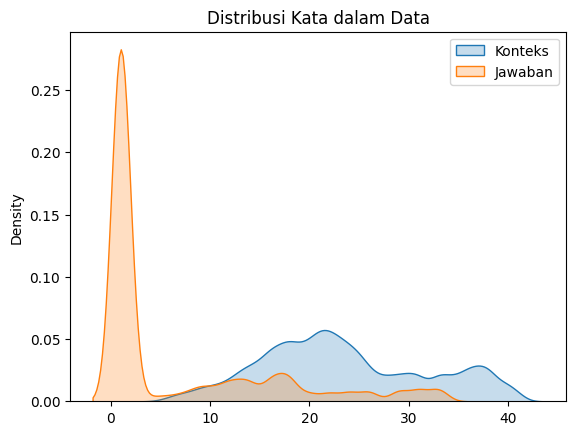

In [17]:
# Buat fungsi untuk mengukur jumlah kata
def get_len_char(text):
    return len(text.split(' '))

# Hitung jumlah kata yang muncul dari setiap konteks
konteks_len = [get_len_char(teks) for teks in data['context']]

# Hitung jumlah kata yang muncul dari setiap jawaban
jawaban_len = [get_len_char(jawab['text'][0]) for jawab in data['answers']]

# Tampilkan diagram distribusi
sns.kdeplot(
    x = konteks_len,
    fill = True,
    label = 'Konteks'
)
sns.kdeplot(
    x = jawaban_len,
    fill = True,
    label = 'Jawaban'
)
plt.title('Distribusi Kata dalam Data')
plt.legend()
plt.show()

Disini dapat dilihat bahwa
* Mayoritas jumlah kata yang muncul dalam teks jawaban sangat sedikit, hal ini masuk akal karena dalam data yang dibuat, mayoritas kata yang digunakan hanya sedikit kecuali saat ditanyakan jenis barang dan jumlahnya
* Mayoritas jumlah kata yang muncul dalam teks konteks berkisar antara 20 - 23 kata, tidak melebihi maksimal jumlah token dari suatu model BERT (sekitar 500 token).

Selanjutnya, akan dilihat persebaran jumlah barang yang disebut dalam masing-masing teks

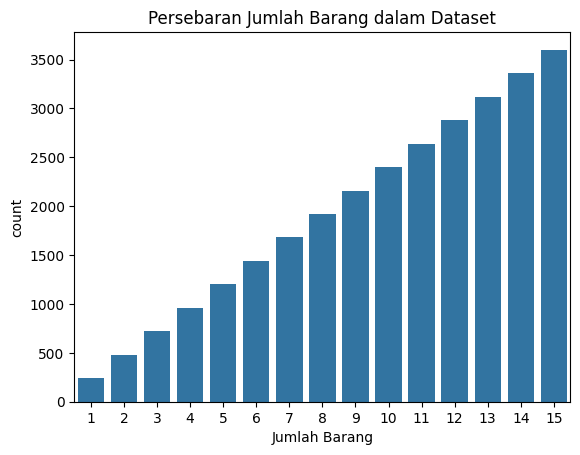

In [22]:
# Buat pandas dataframe object
df = pd.DataFrame(
    {'Konteks': data['context'],
     'Pertanyaan': data['question'],
     'Jawaban': [ans['text'][0] for ans in data['answers']]
    }
)

# Filter pada pertanyaan Apa saja barang yang dipesan
sub_df = df[df['Pertanyaan'] == 'Apa saja barang yang dipesan?'].copy()

# Dapatkan jumlah barang yang disebut dengan filter kata ,
sub_df['Jumlah Barang'] = sub_df['Jawaban'].apply(lambda ans: len(ans.split(',')))

# Tampilkan distribusi jumlah barang
sns.countplot(
    data = sub_df,
    x = 'Jumlah Barang'
)
plt.title('Persebaran Jumlah Barang dalam Dataset')
plt.show()

Dari sini, dapat dilihat bahwa semakin tinggi jumlah barang yang digunakan, semakin tinggi jumlah observasi teks yang digunakan. Hal ini dikarenakan proses shuffling yang menciptakan lebih banyak kombinasi pasangan barang dan jumlah barang saat barangnya semakin banyak.

## 2.1. Convert data dictionary menjadi HuggingFace Dataset Object
Untuk melatih model IndoBERT, kita dapat mengubah data sintetis menjadi objek datasets sehingga dapat dilakukan pemrosesan data seperti tokenisasi.

Setelah mengubah data menjadi objek datasets, kita akan split data menjadi data training dan test

In [5]:
# Load dataset into Hugginface datasets' object
dataset = Dataset.from_dict(data)

# Split dataset into train and test
split_dataset = dataset.train_test_split(test_size=0.2)

# The split_dataset is a DatasetDict containing 'train' and 'test' sets
print(split_dataset)

DatasetDict({
    train: Dataset({
        features: ['answers', 'context', 'id', 'question'],
        num_rows: 69120
    })
    test: Dataset({
        features: ['answers', 'context', 'id', 'question'],
        num_rows: 17280
    })
})


Save data ke dalam HuggingFace dengan login melalui CLI di bawah ini

In [147]:
from huggingface_hub import notebook_login
notebook_login()

In [148]:
split_dataset.push_to_hub('andikazf15/indo_product_inference')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/70 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/andikazf15/indo_product_inference/commit/12364a9eb2bd62ea2f219c1a1de256847b747d15', commit_message='Upload dataset', commit_description='', oid='12364a9eb2bd62ea2f219c1a1de256847b747d15', pr_url=None, pr_revision=None, pr_num=None)

## 2.2. Tokenisasi Data
Agar model IndoBERT dapat mengkonsumsi data, kita perlu mengubah data teks menjadi suatu vektor.

Vektor ini beranggotakan angka yang merupakan pemetaan suatu token (dapat berupa kata atau kumpulan beberapa kata)

Dalam proses tokenisasi, kita ingin memberikan label yang dapat diprediksi oleh model. Label ini melingkupi rentang indeks jawaban yang ditemukan dalam teks.


Sebagai contoh, diberikan konteks dan pertanyaan sebagai berikut:
```
### KONTEKS
Saya mau membeli 1 pisang, 2 apel.

### PERTANYAAN
Apa saja barang yang dibeli?
```

Hasil akhir tokenisasi ini akan mengubah kedua teks tersebut menjadi teks dengan format `[CLS] ### PERTANYAAN [SEP] ### KONTEKS [SEP]` sebagai berikut

```
[CLS] Apa saja barang yang dibeli? [SEP] Saya mau membeli 1 pisang, 2 Apel [SEP].
```

Setiap kata tersebut dipetakan menjadi suatu angka, sehingga terbentuk vektor sebagai berikut:

```
[10, 21, 52, 23, 24, 115, 67, 27, 58, 99, 210, 113, 122, 131, 147]
```

Maka, label dari data teks ini adalah rentang indeks (10, 13) dari vektor tersebut yang berkorespodensi dengan kata '1 pisang, 2 apel.'.

Apa yang terjadi jika jawaban dari pertanyaan tersebut tidak disebut dalam konteks? Maka, label dari teks ini adalah indeks (0,0) yang berkorespodensi dengan kata [CLS].

Untuk memudahkan ilustrasi dari penjelasan di atas, kita akan mencoba melakukan proses tokenisasi pada beberapa sampel teks

In [6]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("rizquuula/mBERT-IndoSQuADv2_1691852742-16-2e-06-0.01-5")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Ada beberapa parameter yang ditentukan dalam objek tokenizer ini, yakni:
* `max_length`: Panjang konteks yang bisa diterima oleh model. Dalam hal ini, karena teks yang kita gunakan panjangnya cukup kecil kita bisa gunakan 100 token sebagai batas maksimum jumlah token.
* `stride`: Seberapa banyak token yang diskip jika konteks tersebut melebihi `max_length`. Jika `stride = 50`, maka kita akan mengabaikan 50 token setelah penggalan konteks sebelumnya, lalu lanjut proses tokenisasi setelah melalui 50 token tersebut
* `truncation`: Memotong teks input jika teks tersebut lebih panjang dari `max_length`, jika menggunakan `truncation="only_second"`, berarti kita hanya memotong teks dari input kedua yaitu (konteks dari QA)

In [7]:
# Lakukan proses tokenisasi
inputs = tokenizer(
    split_dataset["train"][2:6]["question"],
    split_dataset["train"][2:6]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

# Loop setiap hasil tokenisasi
for ids in inputs["input_ids"]:
  print(tokenizer.decode(ids))

[CLS] Ke mana barang tersebut dikirim? [SEP] Tolong kirimkan batu bata, meja, setrika, lemari, sumpit korea, sofa, gelas, sendok, teko, mangkok, baju bekas, piring, botol, rak, kursi ke Bandung [SEP]
[CLS] Apa saja barang yang dipesan? [SEP] Saya mau memesan mangkok, teko, sumpit korea, gelas, sendok, kursi, meja, batu bata, sofa, piring, botol ke Yogyakarta [SEP]
[CLS] Apa saja barang yang dipesan? [SEP] Tolong kirimkan batu bata, lemari, rak, teko, sumpit korea, gelas, sendok, piring, mangkok, meja, botol, baju bekas, sofa, kursi, setrika dengan motif floral ke Bandung [SEP]
[CLS] Apa motif barang yang dipesan? [SEP] Saya mau memesan sendok, botol, batu bata, sumpit korea, baju bekas, lemari, teko, setrika, gelas, piring, mangkok, meja, kursi, sofa ke Jakarta [SEP]


Hasil dari tokenisasi menunjukkan format yang sama dengan bagian contoh di atas, sekarang kita akan melakukan labeling dari sampel data tersebut

In [8]:
answers = split_dataset["train"][2:6]["answers"]
start_positions = []
end_positions = []

for i, offset in enumerate(inputs["offset_mapping"]):
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    answer = answers[sample_idx]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Temukan indeks awal konteks dan indeks akhir konteks
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # Jika answer_start = -1, maka ini berarti jawaban tidak ada di teks, jadi isi dengan label (0, 0)
    if start_char == -1:
        start_positions.append(0)
        end_positions.append(0)

     # Jika jawaban tidak terkandung dalam konteks, maka ini berarti jawaban tidak ada di teks, jadi isi dengan label (0, 0)
    elif offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Cari label indeks jawaban dalam teks tersebut
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

print('Indeks awal dari penggalan jawaban:', start_positions)
print('Indeks akhir dari penggalan jawabn:', end_positions)

Indeks awal dari penggalan jawaban: [63, 17, 16, 0]
Indeks akhir dari penggalan jawabn: [63, 51, 62, 0]


Dari hasil ini, kita mungkin peroleh beberapa pertanyaan yang berlabel (0, 0).

In [9]:
# Gunakan contoh pertama
idx = 0

# Dapatkan pemetaan jawaban
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]
start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])

# Print hasil pemetaan jawaban
print(f"Jawaban sebenarnya: {answer}, Label teks: {labeled_answer}")

Jawaban sebenarnya: Bandung, Label teks: Bandung


Dalam hal ini, kita dapat melihat apabila jawaban sebenarnya sama dengan label, maka pemetaan label sudah benar.

Jika berbeda, maka jawaban tersebut tidak terkandung ke dalam konteks sehingga labelnya '[CLS]'

Sekarang, lakukan proses tokenisasi pada data training dan test

In [10]:
# Definisikan max length dan stride
max_length = 100
stride = 50

def preprocess_training_examples(examples):
  questions = [q.strip() for q in examples["question"]]
  inputs = tokenizer(
    questions,
    examples["context"],
    max_length=max_length,
    truncation="only_second",
    stride=stride,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    padding="max_length",
  )

  answers = examples["answers"]
  start_positions = []
  end_positions = []

  for i, offset in enumerate(inputs["offset_mapping"]):
      sample_idx = inputs["overflow_to_sample_mapping"][i]
      answer = answers[sample_idx]
      start_char = answer["answer_start"][0]
      end_char = answer["answer_start"][0] + len(answer["text"][0])
      sequence_ids = inputs.sequence_ids(i)

      # Temukan indeks awal konteks dan indeks akhir konteks
      idx = 0
      while sequence_ids[idx] != 1:
          idx += 1
      context_start = idx
      while sequence_ids[idx] == 1:
          idx += 1
      context_end = idx - 1

      # Jika answer_start = -1, maka ini berarti jawaban tidak ada di teks, jadi isi dengan label (0, 0)
      if start_char == -1:
          start_positions.append(0)
          end_positions.append(0)

      # Jika jawaban tidak terkandung dalam konteks, maka ini berarti jawaban tidak ada di teks, jadi isi dengan label (0, 0)
      elif offset[context_start][0] > start_char or offset[context_end][1] < end_char:
          start_positions.append(0)
          end_positions.append(0)
      else:
          # Cari label indeks jawaban dalam teks tersebut
          idx = context_start
          while idx <= context_end and offset[idx][0] <= start_char:
              idx += 1
          start_positions.append(idx - 1)

          idx = context_end
          while idx >= context_start and offset[idx][1] >= end_char:
              idx -= 1
          end_positions.append(idx + 1)

  inputs["start_positions"] = start_positions
  inputs["end_positions"] = end_positions
  return inputs

In [11]:
# Lakukan pemetaan pada data training
train_dataset = split_dataset["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=split_dataset["train"].column_names,
)
len(split_dataset["train"])

Map:   0%|          | 0/69120 [00:00<?, ? examples/s]

69120

Hal yang sama kita lakukan pada data test, tetapi kita tidak perlu membuat label dari data validasi karena dalam proses training nanti yang perlu kita lihat adalah metrik yang didefinisikan pada bagian evaluasi model.

In [12]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [13]:
validation_dataset = split_dataset["test"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=split_dataset["test"].column_names,
)
len(split_dataset["test"])

Map:   0%|          | 0/17280 [00:00<?, ? examples/s]

17280

# 3. Fine Tuning IndoBERT
Pada kasus ini kita akan menggunakan model IndoBERT dalam melakukan inferensi jawaban dari pertanyaan dan konteks yang diberikan. Untuk meningkatkan performa model IndoBERT, kita akan melakukan proses *fine tuning* yaitu melatih model IndoBERT pada data sintetis yang telah kita buat pada bagian Pembuatan Data


## 3.1. IndoBERT Fine-Tuning
Pada proses ini akan dilakukan proses training dengan menggunakan model IndoBERT.



In [14]:
# Buat data collator untuk membuat kumpulan batch training data
data_collator = DefaultDataCollator()

In [17]:
# Definisikan model
model = AutoModelForQuestionAnswering.from_pretrained("rizquuula/mBERT-IndoSQuADv2_1691852742-16-2e-06-0.01-5")

Lakukan proses training

In [18]:
# Define training argument
training_args = TrainingArguments(
    output_dir="IndoBERT-QA-product-pred",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss
500,0.024800
1000,0.007500
1500,0.005300
2000,0.000000
2500,0.000300
3000,0.001700
3500,0.000200
4000,0.000400
4500,0.001200
5000,0.000400


Step,Training Loss
500,0.024800
1000,0.007500
1500,0.005300
2000,0.000000
2500,0.000300
3000,0.001700
3500,0.000200
4000,0.000400
4500,0.001200
5000,0.000400


TrainOutput(global_step=25920, training_loss=0.0010602017542646256, metrics={'train_runtime': 3345.5835, 'train_samples_per_second': 61.98, 'train_steps_per_second': 7.748, 'total_flos': 1.0582518647808e+16, 'train_loss': 0.0010602017542646256, 'epoch': 3.0})

## 3.2. Evaluasi Hasil Fine-Tuning
Mari kita lihat evaluasi model yang telah di fine-tuning pada data sintetis,

Evaluasi hasil fine-tuning menggunakan 2 metrik yaitu:
* Exact Match
* F1 score

Pada bagian evaluasi ini, model akan memberikan 20 prediksi dari label rentang indeks jawaban pertanyaan tersebut. Jika model tidak mengeluarkan prediksi jawaban, maka akan diisi dengan teks kosong ''

In [26]:
# Definisikan parameter evaluasi
n_best = 20
max_answer_length = 30
predicted_answers = []
em_metric = evaluate.load("squad")

In [28]:
# Definisikan fungsi evaluasi
def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop semua contoh dalam data example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip jawaban yang tidak ada di konteks
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip jawaban dengan panjang index that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Pilih jawaban dengan skor tertinggi
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return em_metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [29]:
# Evaluasi pada data validasi
predictions, _, _ = trainer.predict(validation_dataset)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, validation_dataset, split_dataset["test"])

  0%|          | 0/17280 [00:00<?, ?it/s]

{'exact_match': 55.81597222222222, 'f1': 56.67690268842284}

Dengan menggunakan fine-tuning kita dapat memperoleh skor 56% pada data test. Kemungkinan besar, model masih mengalami kesulitan dalam memprediksi kalimat dengan barang yang banyak atau informasi yang tidak lengkap

Save model ini ke dalam Hugging Face

In [88]:
# Save to hub
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/andikazf15/IndoBERT-QA-product-pred/commit/b321b7f9264700248dc54b027ffd73829f327f39', commit_message='End of training', commit_description='', oid='b321b7f9264700248dc54b027ffd73829f327f39', pr_url=None, pr_revision=None, pr_num=None)

# Inferensi Model
Sekarang dengan menggunakan model yang telah di fine-tuning kita dapat memperoleh informasi terkait pengiriman barang dengan menjalankan fungsi di bawah. Fungsi di bawah dapat melakukan filtering jawaban dari model sehingga kita tidak terlalu bergantung pada jawaban dari model tersebut.

Kita dapat menggunakan model yang telah disimpan pada HuggingFace atau dengan menggunakan lokasi folder model tersebut

In [30]:
# Definisikan pipeline untuk QA
question_answerer = pipeline("question-answering", model="IndoBERT-QA-product-pred")

In [31]:
# Buat fungsi untuk inferensi teks
def extract_information(context):
  print('Konteks:', context)
  print('--------------------------------------------')

  # Dapatkan informasi barang dan jumlah barang
  quest = 'Apa saja barang yang ia beli?'
  answer = question_answerer(question=quest, context=context)

  # Bersihkan teks jawaban barang
  barang = re.sub('\d+', '', answer['answer'])
  barang = re.sub(' ', '', barang)
  barang = re.sub('(dan|,)', '; ', barang).strip()

  # Bersihkan teks jawaban jumlah barang
  jumlah_barang = '; '.join(re.findall('\d+', answer['answer']))

  print('Nama barang:', barang)
  print('Jumlah barang:', jumlah_barang)

  # Dapatkan informasi motif
  quest = 'Apa motif barang yang dipesan?'
  answer = question_answerer(question=quest, context=context, handle_impossible_answer = True)

  print('Motif:', answer['answer'] if answer['score'] > 0.97 else '')

  # Dapatkan informasi lokasi
  quest = 'Ke mana barang tersebut dikirim?'
  answer = question_answerer(question=quest, context=context, handle_impossible_answer = True)

  print('Lokasi Pengiriman:', answer['answer'])

In [33]:
extract_information('Saya mau memesan 10 piring, 20 gelas, 30 guling, 40 karet, 50 meja dengan motif A ke Tangerang Selatan Raya')

Konteks: Saya mau memesan 10 piring, 20 gelas, 30 guling, 40 karet, 50 meja dengan motif A ke Tangerang Selatan Raya
--------------------------------------------
Nama barang: 
Jumlah barang: 10
Motif: A
Lokasi Pengiriman: 


Model ini memiliki beberapa limitasi:
* Ketika list barang beserta jumlah barang yang diberikan makin banyak, maka hasil prediksi nama dan jumlah barang dapat salah. Bisa dicoba dengan kalimat konteks berikut

```
Saya mau memesan 10 piring, 20 gelas, 30 guling, 40 karet, 50 meja dengan motif A ke Tangerang Selatan Raya
```

* Tetapi jika inputnya tidak melibatkan jumlah dari tiap barang maka hasilnya dapat benar. Untuk mengecek, kita dapat menggunakan kalimat konteks sebelumnya tanpa jumlah masing-masing barang

```
Saya mau memesan piring, gelas, guling, karet, meja dengan motif A ke Tangerang Selatan Raya
```

* Kalimat konteks yang informasinya tidak lengkap dapat menghasilkan jawaban yang salah

* Kalimat konteks yang melibatkan beberapa pasang kata dalam motif/lokasi dapat memberikan jawaban yang kurang akurat seperti contoh berikut, hasil prediksi hanya mengambil kata 'Jerman' dalam lokasi

```
Saya mau memesan piring, gelas, guling, karet, meja dengan motif A ke Jerman Barat Daya
```


Selain menggunakan fungsi di atas, kita bisa juga mengunjungi Huggingface space berikut [Auto Ekstrak Infor Pengiriman](https://huggingface.co/spaces/andikazf15/auto_ekstrak_info_pengiriman) untuk mencoba berbagai kalimat konteks

# Referensi
* [Fine Tuning the Model with Trainer API](https://huggingface.co/learn/nlp-course/en/chapter7/7#fine-tuning-the-model-with-the-trainer-api)
